# Preparing Data and Library

## Import Library

In [1]:
from sklearn.datasets import load_files
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt
import os, random, pathlib, warnings, itertools, math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D, Activation, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from IPython.display import Image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger

## Import Data Image

In [2]:
ds = r'C:\Users\uSeR\Downloads\dataset-resized'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

x_train, y_train,target_labels = load_dataset(ds)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])

Loading complete!
Training set size :  2527


In [3]:
garbage_types = os.listdir(ds)

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(ds, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

cardboard folder contains 403 images.
glass folder contains 501 images.
metal folder contains 410 images.
paper folder contains 594 images.
plastic folder contains 482 images.
trash folder contains 137 images.


# Processing Image

## Augmentation Image

In [4]:
# Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=20,                  # Rotate image by up to 20 degrees
    width_shift_range=0.2,              # shift images horizontally by up to 20% of the width
    height_shift_range=0.2,             # shift images vertically by up to 20% of the height
    horizontal_flip=True,               # flip images horizontally
    vertical_flip=True,                 # flip images vertically
    brightness_range=[0.8, 1.2],        # Vary brightness between 80% to 120% of original
    zoom_range=0.2,                     # Zoom in or out by up to 20%
    validation_split=0.2                # Split data into training and validation sets
)

# Generator validasi
val_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize
    validation_split=0.2                # Split data into training and validation sets
)

# Load data
train_generator = train_datagen.flow_from_directory(
    ds,
    target_size=(224, 224),
    batch_size=32,
    seed=42,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    ds,
    target_size=(224, 224),
    batch_size=32,
    seed=42,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [5]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [3]:

# Mendapatkan satu batch gambar dan label
images, labels = next(train_generator)
# Menampilkan gambar pertama
plt.imshow(images[0])
plt.title(f"Label: {labels[0]}")
plt.show()


NameError: name 'train_generator' is not defined

# Make a Model

# Scratch a Model

In [7]:
model = Sequential()
#Input Layer
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(224, 224, 3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

#Hidden Layer 1
model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

#Hidden Layer 2
model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

#Hidden Layer 3
model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

#Output Layer
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(6,activation = 'softmax'))
model.summary()

c:\Program Files\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │     3,763,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           906 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,808,656 (14.53 MB)

 Trainable params: 3,808,176 (14.53 MB)

 Non-trainable params: 480 (1.88 KB)

## Plotting Model

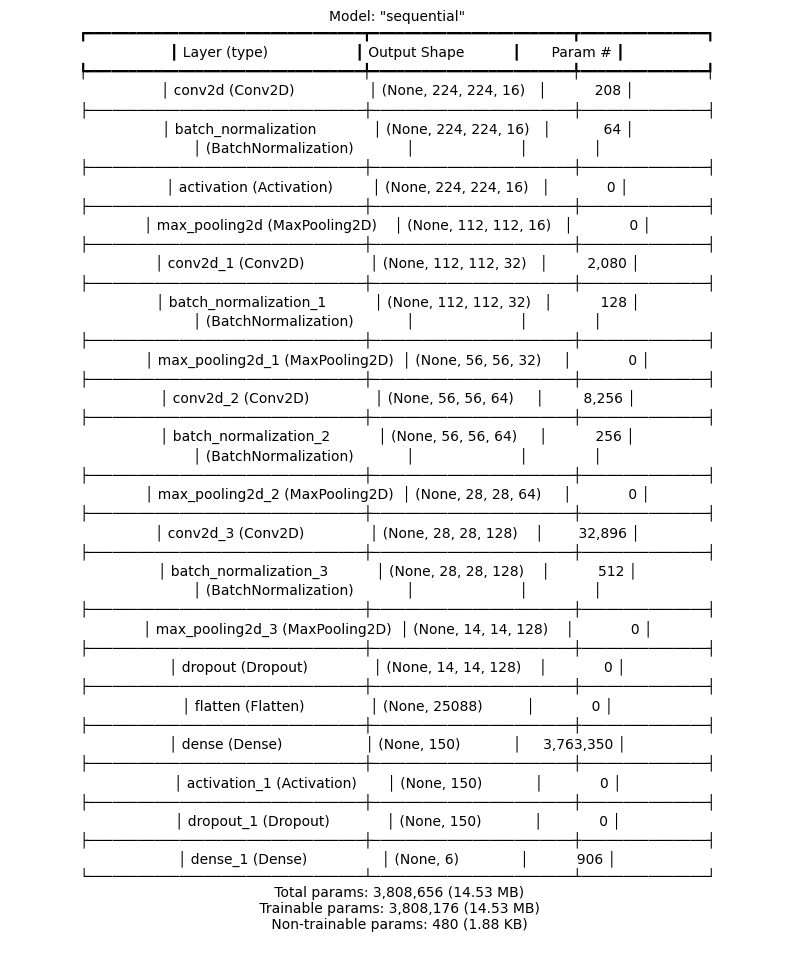

In [8]:
def visualize_model_summary(model):
    lines = []
    model.summary(print_fn=lambda x: lines.append(x))
    summary_text = "\n".join(lines)
    
    # Visualisasi teks menggunakan Matplotlib
    plt.figure(figsize=(10, len(lines) * 0.4))
    plt.text(0.5, 0.5, summary_text, fontsize=10, ha='center', va='center', wrap=True)
    plt.axis('off')
    plt.show()

# Panggil fungsi visualisasi
visualize_model_summary(model)

## Compile Model

In [9]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  run_eagerly=True,
  metrics=['accuracy']
)
print('Compiled!')

Compiled!


## Callback for Model

In [10]:
# Callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Monitor Validation Loss Metric
    factor=0.5,               # Reduce learning rate around 50%
    patience=5,               # Reduce Learning Rate if didn't improvement while 5 epoch
    verbose=1,                # Showing Log
    min_lr=1e-6               # Learning rate minimum
)

# Callback ModelCHeckpoint
checkpointer = ModelCheckpoint(
    filepath = 'cnn_item.keras',
    verbose = 1,
    save_best_only = True)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',            # Monitor Validation Loss Metric
    patience=8,                    # Wait 8 Epoch
    restore_best_weights=True,     # Return to best weight
    verbose=1                      # Show Log
)

## Train Model

In [11]:
wandb.require("legacy-service")

In [17]:
import wandb
from wandb.integration.keras import WandbCallback

# Start W&B
wandb.init(
    project="LimbahDaurUlang_Baru",
    # config={
    #     "learning_rate": 0.02,
    #     "architecture": "CNN",
    #     "dataset": "CIFAR-100",
    #     "epochs": 15,
    # }
)

# Custom callback untuk menyimpan model
from tensorflow.keras.callbacks import Callback

class CustomSaveCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Simpan model di setiap akhir epoch
        model.save(f"model_epoch_{epoch + 1}.h5")

custom_save_callback = CustomSaveCallback()

# Training model
history = model.fit(
    train_generator,
    batch_size=32,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpointer, reduce_lr, early_stopping, WandbCallback(save_graph=False, save_model=False), custom_save_callback],
    verbose=2,
    shuffle=True,
)

wandb.finish()


Epoch 1/50

Epoch 1: val_loss did not improve from 1.34159


64/64 - 114s - 2s/step - accuracy: 0.4570 - loss: 1.3824 - val_accuracy: 0.3837 - val_loss: 1.5821 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss did not improve from 1.34159


64/64 - 125s - 2s/step - accuracy: 0.4699 - loss: 1.3282 - val_accuracy: 0.4573 - val_loss: 1.3783 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss did not improve from 1.34159


64/64 - 121s - 2s/step - accuracy: 0.4713 - loss: 1.3515 - val_accuracy: 0.3598 - val_loss: 1.6807 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 1.34159 to 1.29492, saving model to cnn_item.keras


64/64 - 118s - 2s/step - accuracy: 0.4718 - loss: 1.2980 - val_accuracy: 0.4851 - val_loss: 1.2949 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss did not improve from 1.29492


64/64 - 117s - 2s/step - accuracy: 0.4936 - loss: 1.2866 - val_accuracy: 0.3917 - val_loss: 1.5323 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: val_loss did not improve from 1.29492


64/64 - 109s - 2s/step - accuracy: 0.5015 - loss: 1.2652 - val_accuracy: 0.4354 - val_loss: 1.4081 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: val_loss did not improve from 1.29492


64/64 - 111s - 2s/step - accuracy: 0.4827 - loss: 1.3097 - val_accuracy: 0.4632 - val_loss: 1.3844 - learning_rate: 0.0010
Epoch 8/50

Epoch 8: val_loss did not improve from 1.29492


64/64 - 112s - 2s/step - accuracy: 0.4960 - loss: 1.2742 - val_accuracy: 0.3201 - val_loss: 2.7429 - learning_rate: 0.0010
Epoch 9/50

Epoch 9: val_loss did not improve from 1.29492

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


64/64 - 112s - 2s/step - accuracy: 0.5084 - loss: 1.2593 - val_accuracy: 0.4016 - val_loss: 1.6893 - learning_rate: 0.0010
Epoch 10/50

Epoch 10: val_loss improved from 1.29492 to 1.27187, saving model to cnn_item.keras


64/64 - 114s - 2s/step - accuracy: 0.5316 - loss: 1.1953 - val_accuracy: 0.4791 - val_loss: 1.2719 - learning_rate: 5.0000e-04
Epoch 11/50

Epoch 11: val_loss did not improve from 1.27187


64/64 - 118s - 2s/step - accuracy: 0.5361 - loss: 1.2183 - val_accuracy: 0.5408 - val_loss: 1.2751 - learning_rate: 5.0000e-04
Epoch 12/50

Epoch 12: val_loss improved from 1.27187 to 1.26140, saving model to cnn_item.keras


64/64 - 121s - 2s/step - accuracy: 0.5400 - loss: 1.1862 - val_accuracy: 0.4672 - val_loss: 1.2614 - learning_rate: 5.0000e-04
Epoch 13/50

Epoch 13: val_loss did not improve from 1.26140


64/64 - 116s - 2s/step - accuracy: 0.5292 - loss: 1.2248 - val_accuracy: 0.4970 - val_loss: 1.3113 - learning_rate: 5.0000e-04
Epoch 14/50

Epoch 14: val_loss did not improve from 1.26140


64/64 - 119s - 2s/step - accuracy: 0.5440 - loss: 1.1533 - val_accuracy: 0.4592 - val_loss: 1.4473 - learning_rate: 5.0000e-04
Epoch 15/50

Epoch 15: val_loss did not improve from 1.26140


64/64 - 115s - 2s/step - accuracy: 0.5509 - loss: 1.1462 - val_accuracy: 0.4990 - val_loss: 1.3025 - learning_rate: 5.0000e-04
Epoch 16/50

Epoch 16: val_loss did not improve from 1.26140


64/64 - 116s - 2s/step - accuracy: 0.5667 - loss: 1.1339 - val_accuracy: 0.4493 - val_loss: 1.5328 - learning_rate: 5.0000e-04
Epoch 17/50

Epoch 17: val_loss did not improve from 1.26140

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


64/64 - 115s - 2s/step - accuracy: 0.5459 - loss: 1.1610 - val_accuracy: 0.4791 - val_loss: 1.2932 - learning_rate: 5.0000e-04
Epoch 18/50

Epoch 18: val_loss improved from 1.26140 to 1.22612, saving model to cnn_item.keras


64/64 - 119s - 2s/step - accuracy: 0.5751 - loss: 1.1319 - val_accuracy: 0.5209 - val_loss: 1.2261 - learning_rate: 2.5000e-04
Epoch 19/50

Epoch 19: val_loss improved from 1.22612 to 1.16704, saving model to cnn_item.keras


64/64 - 121s - 2s/step - accuracy: 0.5909 - loss: 1.1048 - val_accuracy: 0.5129 - val_loss: 1.1670 - learning_rate: 2.5000e-04
Epoch 20/50

Epoch 20: val_loss improved from 1.16704 to 1.15773, saving model to cnn_item.keras


64/64 - 116s - 2s/step - accuracy: 0.5870 - loss: 1.0977 - val_accuracy: 0.5368 - val_loss: 1.1577 - learning_rate: 2.5000e-04
Epoch 21/50

Epoch 21: val_loss improved from 1.15773 to 1.13395, saving model to cnn_item.keras


64/64 - 115s - 2s/step - accuracy: 0.5875 - loss: 1.0725 - val_accuracy: 0.5388 - val_loss: 1.1339 - learning_rate: 2.5000e-04
Epoch 22/50

Epoch 22: val_loss did not improve from 1.13395


64/64 - 118s - 2s/step - accuracy: 0.5899 - loss: 1.0692 - val_accuracy: 0.5249 - val_loss: 1.3186 - learning_rate: 2.5000e-04
Epoch 23/50

Epoch 23: val_loss did not improve from 1.13395


64/64 - 112s - 2s/step - accuracy: 0.5875 - loss: 1.0815 - val_accuracy: 0.5427 - val_loss: 1.1943 - learning_rate: 2.5000e-04
Epoch 24/50

Epoch 24: val_loss did not improve from 1.13395


64/64 - 120s - 2s/step - accuracy: 0.6033 - loss: 1.0514 - val_accuracy: 0.5229 - val_loss: 1.2347 - learning_rate: 2.5000e-04
Epoch 25/50

Epoch 25: val_loss did not improve from 1.13395


64/64 - 114s - 2s/step - accuracy: 0.6033 - loss: 1.0315 - val_accuracy: 0.5388 - val_loss: 1.2344 - learning_rate: 2.5000e-04
Epoch 26/50

Epoch 26: val_loss did not improve from 1.13395

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


64/64 - 103s - 2s/step - accuracy: 0.5884 - loss: 1.0637 - val_accuracy: 0.5249 - val_loss: 1.2068 - learning_rate: 2.5000e-04
Epoch 27/50

Epoch 27: val_loss did not improve from 1.13395


64/64 - 108s - 2s/step - accuracy: 0.5904 - loss: 1.0449 - val_accuracy: 0.5467 - val_loss: 1.1564 - learning_rate: 1.2500e-04
Epoch 28/50

Epoch 28: val_loss did not improve from 1.13395


64/64 - 109s - 2s/step - accuracy: 0.5944 - loss: 1.0499 - val_accuracy: 0.5328 - val_loss: 1.3085 - learning_rate: 1.2500e-04
Epoch 29/50

Epoch 29: val_loss did not improve from 1.13395


64/64 - 108s - 2s/step - accuracy: 0.6131 - loss: 1.0155 - val_accuracy: 0.5606 - val_loss: 1.1780 - learning_rate: 1.2500e-04
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 21.


accuracy,▁▂▂▂▃▃▂▃▃▄▅▅▄▅▅▆▅▆▇▇▇▇▇██▇▇▇█
epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
learning_rate,█████████▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▁▁▁
loss,█▇▇▆▆▆▇▆▆▄▅▄▅▄▃▃▄▃▃▃▂▂▂▂▁▂▂▂▁
val_accuracy,▃▅▂▆▃▄▅▁▃▆▇▅▆▅▆▅▆▇▇▇▇▇▇▇▇▇█▇█
val_loss,▃▂▃▂▃▂▂█▃▂▂▂▂▂▂▃▂▁▁▁▁▂▁▁▁▁▁▂▁
accuracy,0.61314
best_epoch,20
best_val_loss,1.13395
epoch,28
learning_rate,0.00013


In [26]:
model.save("Model_Limbah_1.h5")    
model.save("Model_Limbah_1.keras")

## Plot Learning Rate

In [15]:
def plot_learning_curves(history):
    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Add Epoch Column to dataframe
    df['epoch'] = range(1, len(df) + 1)

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15, 6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df['epoch'], y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df['epoch'], y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df['epoch'], y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df['epoch'], y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epoch')

    plt.show()


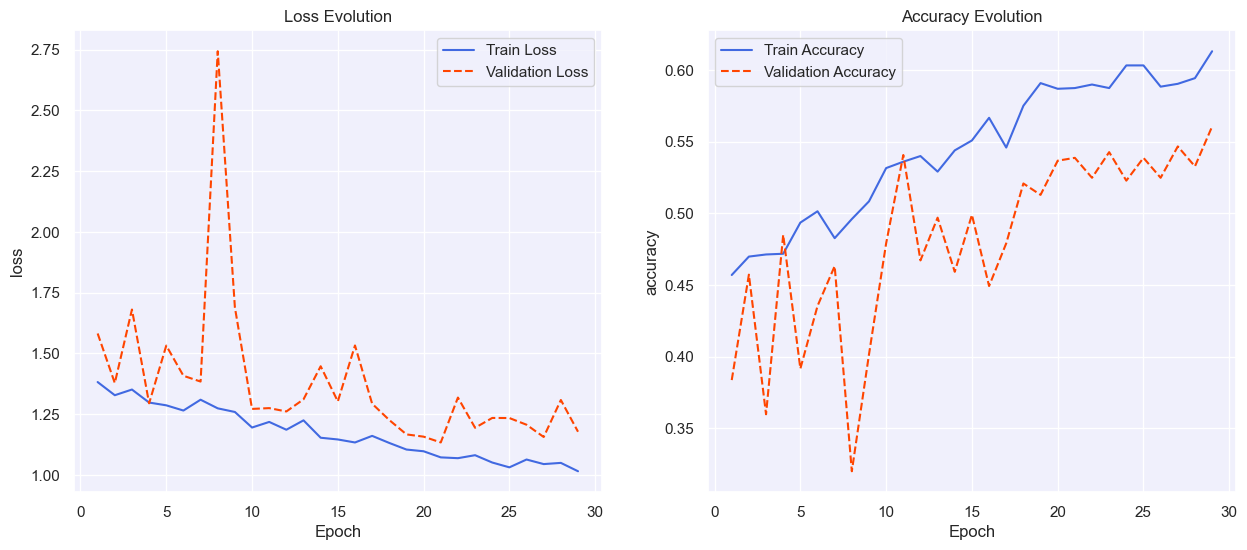

In [18]:
plot_learning_curves(history)

## Plot Model Performance

In [22]:
def evaluate_model_performance(model, val_generator, class_labels):
    # Getting all the true labels for the validation set
    true_labels = validation_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(validation_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(validation_generator, steps=len(validation_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = validation_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [23]:
class_labels = list(validation_generator.class_indices.keys())

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 439ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/st ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/st ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step


c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   cardboard       0.91      0.61      0.73        80
       glass       0.40      0.67      0.50       100
       metal       0.80      0.29      0.43        82
       paper       0.50      0.96      0.66       118
     plastic       0.72      0.19      0.30        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.54       503
   macro avg       0.55      0.45      0.44       503
weighted avg       0.61      0.54      0.50       503





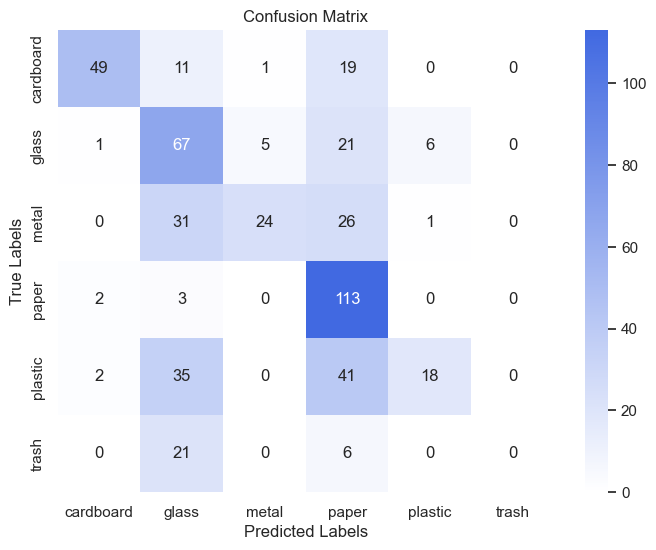

In [24]:
evaluate_model_performance(model, validation_generator, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 572

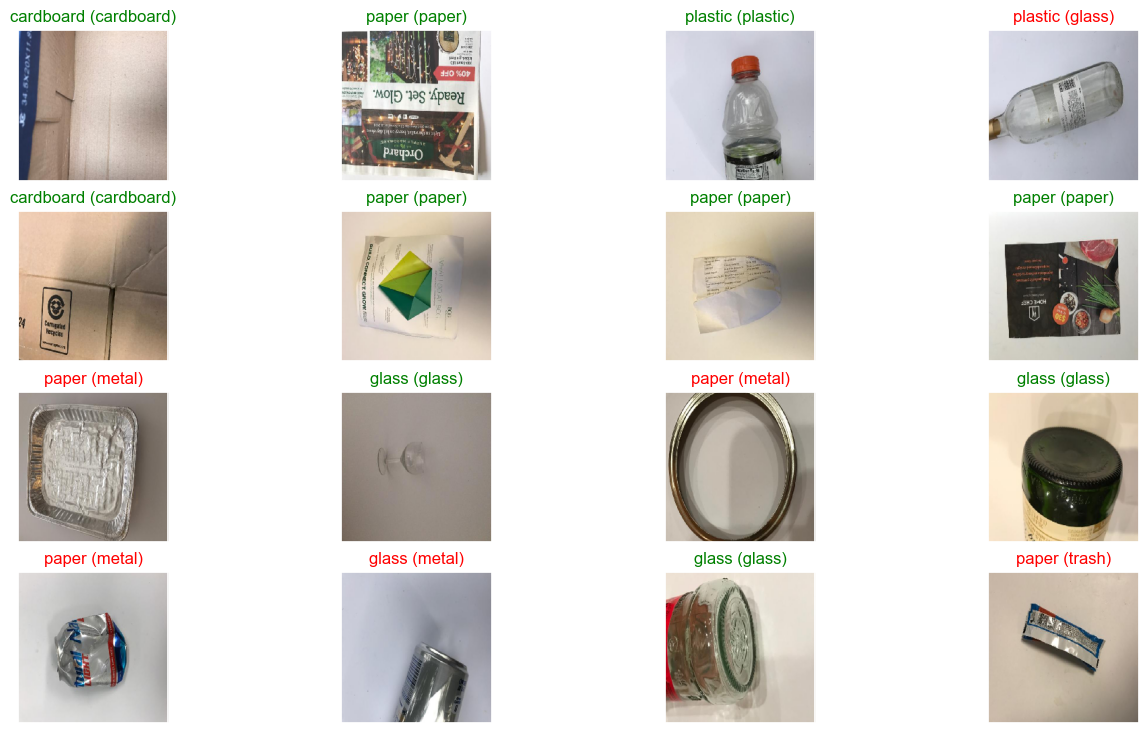

In [25]:
# Iterasi untuk semua batch di validation_generator
all_images = []
all_labels = []
all_preds = []

for images, labels in validation_generator:
    # Prediksi untuk batch saat ini
    preds = model.predict(images)
    all_images.extend(images)
    all_labels.extend(labels)
    all_preds.extend(preds)

    # Berhenti jika semua data sudah diproses
    if len(all_images) >= validation_generator.n:
        break

# Konversi hasil ke array numpy
all_images = np.array(all_images)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Visualisasi
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(len(all_images), size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(all_images[idx])
    pred_idx = np.argmax(all_preds[idx])
    true_idx = np.argmax(all_labels[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))


# Transfer Learning

## Make Pretrained Model Xception

In [29]:
# Load the Xception model with weights pre-trained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/ste ━━━━━━━━━━━━━━━━━━━━ 10:26 7us/ste ━━━━━━━━━━━━━━━━━━━━ 7:42 6us/ste ━━━━━━━━━━━━━━━━━━━━ 10:53 8us/ste ━━━━━━━━━━━━━━━━━━━━ 10:14 7us/ste ━━━━━━━━━━━━━━━━━━━━ 5:44 4us/ste ━━━━━━━━━━━━━━━━━━━━ 5:10 4us/st ━━━━━━━━━━━━━━━━━━━━ 5:38 4us/st ━━━━━━━━━━━━━━━━━━━━ 3:15 2us/st ━━━━━━━━━━━━━━━━━━━━ 2:56 2us/st ━━━━━━━━━━━━━━━━━━━━ 3:11 2us/st ━━━━━━━━━━━━━━━━━━━━ 2:00 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:51 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:58 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:44 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:25 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:26 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:09 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:04 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:15 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:05 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:02 1us/st ━━━━━━━━━━━━━━━━━━━━ 1:03 1us/st ━━━━━━━━━━━━━━━━━━━━ 55s 1us/step ━━━━━━━━━━━━━━━━━━━━ 52s 1us/ste ━━━━━━━━━━━━━━━━━━━━ 54s 1us/ste ━━━━━━━━━━━━━━━━━━━━ 52s 1us/ste ━━━━━━━━━━━━━━━━━━━━ 52s 1us/ste ━━━━━━━━━━━━━━━━━━━━ 50s 1us/ste ━━━━━━━━━━━━━━━━━━

In [30]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

## Freeze Layer

In [31]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name)

0 input_layer_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [32]:
# Freeze the layers
for layer in base_model.layers[:123]: # include the layer 122
    layer.trainable = False

## Build Model

In [33]:
# Create the new model
Xception = base_model.output
Xception = GlobalAveragePooling2D()(Xception)
Xception = Dropout(0.5)(Xception)
Xception = Dense(6, activation='softmax')(Xception)

transfer_Xception_model = Model(inputs=base_model.input, outputs=Xception)

## Compile Model

In [34]:
# Compile Model
transfer_Xception_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower Learning Rate for Greate Transfer Learning
    loss='categorical_crossentropy',      # Clasification Multiclass
    metrics=['accuracy']                  # use Accuracy for Metrics
)

In [35]:
transfer_Xception_model.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,873,774 (79.63 MB)

 Trainable params: 4,763,142 (18.17 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

## Make a Callback ModelCheckpoint for TL Xception

In [36]:
# Callback ModelCheckpoint
checkpointer_Xception = ModelCheckpoint(
    filepath = 'Xception_item.keras',
    verbose = 1,
    save_best_only = True)

## Augmentation Data

In [37]:
train_datagen_Xception = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3,
    validation_split=0.2
)

# Generator validasi
val_datagen_Xception = ImageDataGenerator(
    rescale=1./255,                     
    validation_split=0.2             
)

# Load data
train_generator_Xception = train_datagen_Xception.flow_from_directory(
    ds,
    target_size=(224, 224),
    batch_size=32,
    seed=42,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_generator_Xception = val_datagen_Xception.flow_from_directory(
    ds,
    target_size=(224, 224),
    batch_size=32,
    seed=42,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


## Train Xception Model

In [38]:
# Train the model
history_xception = transfer_Xception_model.fit(train_generator_Xception,
        batch_size = 32,
        steps_per_epoch=len(train_generator_Xception),
        epochs=15,
        validation_data=(validation_generator_Xception),
        validation_steps=len(validation_generator_Xception),
        callbacks = [checkpointer_Xception, reduce_lr, early_stopping],
        verbose=2,
        shuffle=True)

c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15

Epoch 1: val_loss improved from inf to 0.88148, saving model to Xception_item.keras
64/64 - 299s - 5s/step - accuracy: 0.5598 - loss: 1.2374 - val_accuracy: 0.6561 - val_loss: 0.8815 - learning_rate: 1.0000e-04
Epoch 2/15

Epoch 2: val_loss improved from 0.88148 to 0.77634, saving model to Xception_item.keras
64/64 - 300s - 5s/step - accuracy: 0.7554 - loss: 0.7425 - val_accuracy: 0.7455 - val_loss: 0.7763 - learning_rate: 1.0000e-04
Epoch 3/15

Epoch 3: val_loss improved from 0.77634 to 0.63175, saving model to Xception_item.keras
64/64 - 317s - 5s/step - accuracy: 0.7920 - loss: 0.5981 - val_accuracy: 0.7614 - val_loss: 0.6317 - learning_rate: 1.0000e-04
Epoch 4/15

Epoch 4: val_loss improved from 0.63175 to 0.53143, saving model to Xception_item.keras
64/64 - 331s - 5s/step - accuracy: 0.8207 - loss: 0.5255 - val_accuracy: 0.8072 - val_loss: 0.5314 - learning_rate: 1.0000e-04
Epoch 5/15

Epoch 5: val_loss improved from 0.53143 to 0.50699, saving model to Xception_item.ke

## Plot Learning Rate Xception

In [39]:
def plot_learning_curves_Xception(history):
    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Add Epoch Column to dataframe
    df['epoch'] = range(1, len(df) + 1)

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15, 6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df['epoch'], y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df['epoch'], y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df['epoch'], y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df['epoch'], y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epoch')

    plt.show()

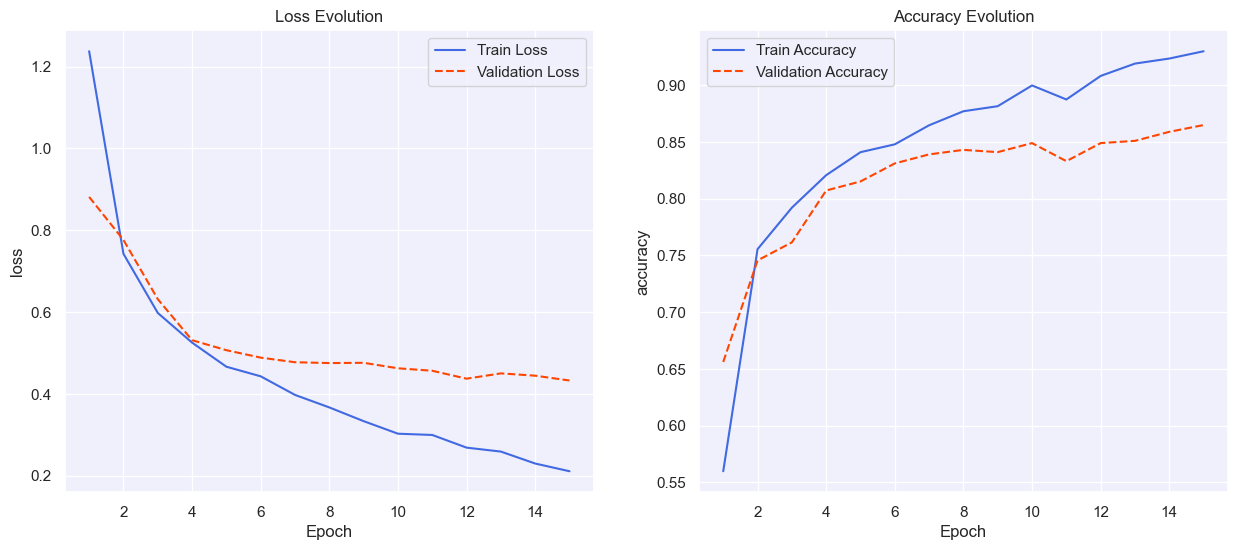

In [40]:
plot_learning_curves_Xception(history_xception)

## Plot Xception Performance

In [41]:
def evaluate_model_performance(model, val_generator, class_labels):
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1:30 6s/ste ━━━━━━━━━━━━━━━━━━━━ 50s 4s/ste ━━━━━━━━━━━━━━━━━━━━ 47s 4s/st ━━━━━━━━━━━━━━━━━━━━ 43s 4s/st ━━━━━━━━━━━━━━━━━━━━ 39s 4s/st ━━━━━━━━━━━━━━━━━━━━ 36s 4s/st ━━━━━━━━━━━━━━━━━━━━ 33s 4s/st ━━━━━━━━━━━━━━━━━━━━ 29s 4s/st ━━━━━━━━━━━━━━━━━━━━ 26s 4s/st ━━━━━━━━━━━━━━━━━━━━ 22s 4s/st ━━━━━━━━━━━━━━━━━━━━ 18s 4s/st ━━━━━━━━━━━━━━━━━━━━ 15s 4s/st ━━━━━━━━━━━━━━━━━━━━ 11s 4s/st ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step ━━━━━━━━━━━━━━━━━━━━ 3s 4s/ste ━━━━━━━━━━━━━━━━━━━━ 0s 4s/ste ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step
              precision    recall  f1-score   support

   cardboard       0.97      0.81      0.88        80
       glass       0.86      0.88      0.87       100
       metal       0.80      0.94      0.87        82
       paper       0.84      0.96      0.90       118
     plastic       0.94      0.77      0.85        96
       trash       0.72      0.67      0.69        27

    accuracy                           0.86       503
   macro avg       0.86    

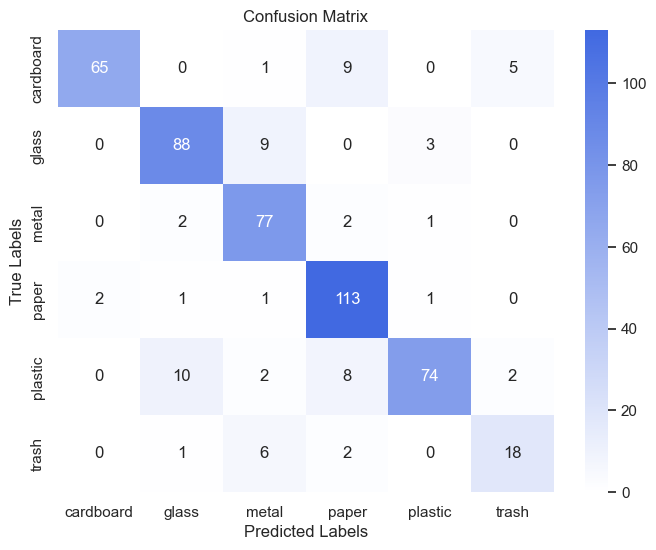

In [42]:
evaluate_model_performance(transfer_Xception_model, validation_generator_Xception, class_labels)

# WANDB

## Login

In [43]:
# Login to wandb account
wandb.login()

True

## Initiate

In [44]:
run = wandb.init(
    # Set the project where this run will be logged
    project="Garbage Classification",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.0001,
        "epochs": 50,
        "batch_size": 32
    },
)

## Train

In [1]:
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[
        WandbMetricsLogger()
    ]
)


NameError: name 'model' is not defined

In [2]:
wandb.finish()

NameError: name 'wandb' is not defined